# Chicago crime dataset analysis
---

This notebook is a Spark and Python learner's to perform data analysis on some real-world data set.

In this notebook, I am capriciously using Spark, Pandas, Matplotlib, Seaborn without any meaningful distinction of purpose. The point is:

 * Perform data reading, transforming, and querying using Apache Spark
 * Visualize using existing Python libraries. Matplotlib will remain when I know to do with it all that I'm currenly using Seaborn for.
 * Where interoperation between Spark and Matplotlib is a hindrance, I use Pandas and Numpy.
 
This will be evolutionary and I hope that a few weeks from now, it will look much better.

---

# How to run this and what to run it on?

---

I wrote this on Apache Spark 2.3.0. The entire notebook was executed on a single machine using the `pyspark` shell without problems.

Here are some important parameters:

 * Executor count: 4
 * Executor Memory: 4G
 * Driver Memory: 8G
 
This may not be necessary, but some data frames are being cached and performance degrades remarkably when the percentage of cached RDDs drops.

So, the command with which the notebook was launched is:

```
pyspark --driver-memory 8g --executor-memory 4g --master local[4]
```

---

## Get Imports out of the way



Spark imports

In [1]:
## spark imports
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

Standard python data analysis imports

In [2]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Jupyter visualization options

In [3]:
%matplotlib inline

#Not too sure the following 2 work. This is a TODO
sns.set_color_codes("pastel")
plt.rcParams["figure.figsize"] = [20, 8]

---
## Dataset information

First, clean the headers. This is just for nice presentation of headers. Having valid data frame field names that conform to Python identifier rules is good. I personally prefer that as it's always helpful to use the dot notation in many places.

These are the column names, as pulled from the Kaggle dataset page [here](https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis)

In [4]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

In [5]:
def entry_dic(line):
    """
    Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
    """
    pair = line.split(' - ')
    return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}

Turn a list of headers to a list of dictionaries produced by the above function

In [6]:
header_dics = list(map(entry_dic, list(filter(lambda l: l != '', content_cols.split('\n')))))

In [7]:
header_dics[:2]

[{'title': 'ID',
  'description': 'Unique identifier for the record.',
  'header': 'id'},
 {'title': 'Case Number',
  'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
  'header': 'case_number'}]

### Environment

The data set is expected to be located at `main folder`. The dataset downloaded from the page mentioned above comes in multiple .csv files. I extracted those files into the directory (see below `ls` output).

It shouldn't matter where the data comes from or how many files it's broken up into. As long as the pattern matches, that should work.

In [8]:
spark = SparkSession.builder.appName("Chicago_crime_analysis").getOrCreate()

---
## Reading the data

Using the Spark's csv reader to parse the files. It processes multiple files and returns a single data frame:

In [9]:
df = spark.read.csv('*.csv', inferSchema=True, header=True)

In [10]:
# Caching this data frame as it's going to be read over and over again
df = df.cache()

In [11]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



---
**Rename columns so that we can use the dot notation**

In [12]:
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])

There's a row that's been identified as having no value for `location_description`. We will just get rid of it right now...

Initially implemented using a `rdd.filter` call. Although, alternatively, one can use the Dataset.filter function

In [13]:
df = df.rdd.filter(lambda rec: rec.arrest.find('Location Description') < 0).toDF().cache()

Taking an initial look at the content of the data frame:

In [14]:
df.show(n=3, truncate=False)

+----+-------+-----------+----------------------+-------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|_c0 |id     |case_number|date                  |block              |iucr|primary_type              |description                  |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on            |latitude    |longitude    |location                     |
+----+-------+-----------+----------------------+-------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|879 |4786321|HM399414   |01/01

---
## Looking at the data

In [15]:
# crime types
crime_type_groups = df.groupBy('primary_type').count()

In [16]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

Total record count

In [17]:
print(df.repartition(1).count())

7941285


How many features do we have

In [18]:
df.columns

['_c0',
 'id',
 'case_number',
 'date',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'latitude',
 'longitude',
 'location']

In [19]:
#Let's see the schema of the data frame:
df.printSchema()

root
 |-- _c0: long (nullable = true)
 |-- id: long (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: string (nullable = true)
 |-- y_coordinate: string (nullable = true)
 |-- year: string (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- location: string (nullable = true)



### Crime types

These are the top 20 most frequent crime types:

In [20]:
crime_type_counts.show(truncate=False)

+--------------------------------+-------+
|primary_type                    |count  |
+--------------------------------+-------+
|THEFT                           |1640506|
|BATTERY                         |1442717|
|CRIMINAL DAMAGE                 |923000 |
|NARCOTICS                       |885431 |
|OTHER OFFENSE                   |491923 |
|ASSAULT                         |481661 |
|BURGLARY                        |470958 |
|MOTOR VEHICLE THEFT             |370548 |
|ROBBERY                         |300453 |
|DECEPTIVE PRACTICE              |280931 |
|CRIMINAL TRESPASS               |229367 |
|PROSTITUTION                    |86401  |
|WEAPONS VIOLATION               |77429  |
|PUBLIC PEACE VIOLATION          |58548  |
|OFFENSE INVOLVING CHILDREN      |51441  |
|CRIM SEXUAL ASSAULT             |29868  |
|SEX OFFENSE                     |28707  |
|GAMBLING                        |18806  |
|LIQUOR LAW VIOLATION            |17513  |
|INTERFERENCE WITH PUBLIC OFFICER|15710  |
+----------

I like doing some things by hand, but it's clear that here, one can obtain a Pandas data frame by calling:

``
crime_type_counts.toPandas()
``

In [21]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda l: l.asDict()).collect())

In [22]:
counts_pddf.head(10)

,primary_type,count
0,THEFT,1640506
1,BATTERY,1442717
2,CRIMINAL DAMAGE,923000
3,NARCOTICS,885431
4,OTHER OFFENSE,491923
5,ASSAULT,481661
6,BURGLARY,470958
7,MOTOR VEHICLE THEFT,370548
8,ROBBERY,300453
9,DECEPTIVE PRACTICE,280931


[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

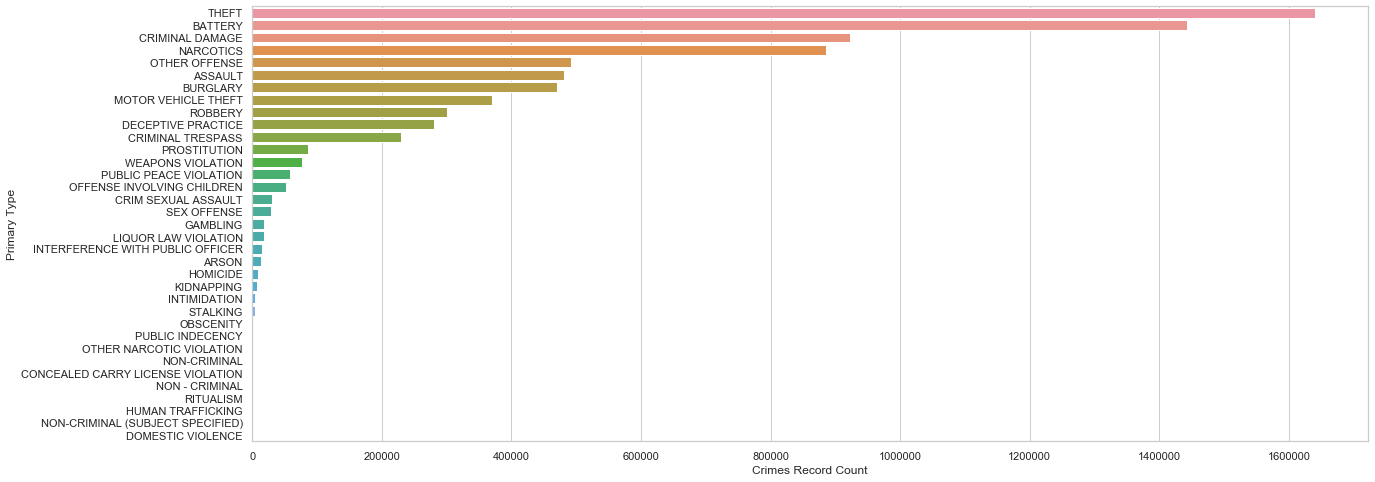

In [23]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

### Recorded Date

In [24]:
import datetime
from pyspark.sql.functions import *

In [25]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2001 01:00:00 AM|12/31/2016 12:56:00 AM|
+----------------------+----------------------+



So it seems that the dataset we're dealing with comprises records from **2001-01-01** to **2016-12-31**

---
Converting dates to a timestamp type. As seen in the schema output above, the `date` field is of `string` type, which won't be very helpful

The format specifier that seems valid for date like '02/23/2006 09:06:22 PM' is **`'MM/dd/yyyy hh:mm:ss a'`**

In [26]:
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'YYYY')) #adding a month column to be able to view stats on a monthly basis

In [27]:
df.select(['date','date_time', 'month'])\
  .show(n=2, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|01/01/2004 12:01:00 AM|2004-01-01 00:01:00|2004-01-01|
|03/01/2003 12:00:00 AM|2003-03-01 00:00:00|2003-01-01|
+----------------------+-------------------+----------+
only showing top 2 rows



### Primary type and arrest

In [28]:
# crime types and arrest over years:
type_arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
print()
type_arrest_date.show(3, truncate=False)


+------+----------+------+
|arrest|month     |count |
+------+----------+------+
|False |2001-01-01|400628|
|True  |2001-01-01|167890|
|False |2002-01-01|348074|
+------+----------+------+
only showing top 3 rows



In [29]:
# A small detour to learn/see how datetime works
import datetime

In [30]:
datetime.datetime.now()
datetime.datetime.strftime(datetime.datetime.now(), '%H')

'10'

In [31]:
# A pandas data frame of the collected dictionary version of the date-grouped DF above
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())

Convert date/time values to Pandas type

*A lot of this is unnecessary, but that's called fiddling...*

In [32]:
type_arrest_pddf['yearpd'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))

In [33]:
type_arrest_pddf['arrest'] = type_arrest_pddf['arrest'].apply(lambda l: l=='True')
type_arrest_pddf.head(5)

,arrest,month,count,yearpd
0,False,2001-01-01,400628,2001
1,True,2001-01-01,167890,2001
2,False,2002-01-01,348074,2002
3,True,2002-01-01,142805,2002
4,False,2003-01-01,334414,2003


### How have arrests evolved over the 16 years?

c:\users\zeust\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


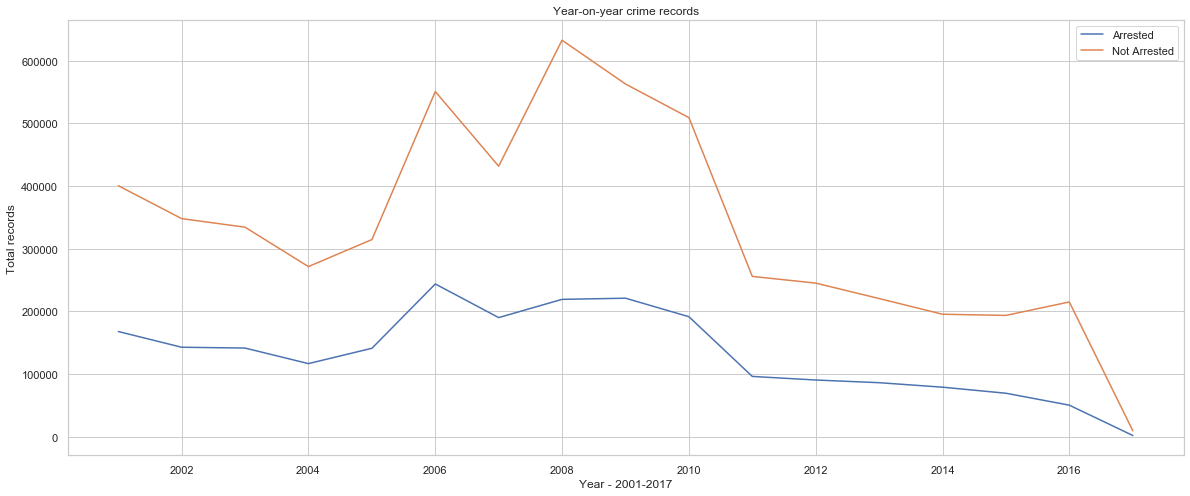

In [34]:
# Data for plotting
t = type_arrest_pddf['count'] - 20 # np.arange(0.0, 2.0, 0.01)
s = type_arrest_pddf['month']

arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == True]
not_arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == False]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Year - 2001-2017', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(b=True, which='both', axis='y')
ax.legend()

It looks like the relative distance between arrests and non-arrests has remained constant..

### What time of the day are ciminal the busiest?

In [35]:
# Extract the "hour" field from the date into a separate column called "hour"
df_hour = df.withColumn('hour', hour(df['date_time']))

In [36]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [37]:
hourly_count_pddf = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())

In [38]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')

Seems that 18-22 are the worst hours...

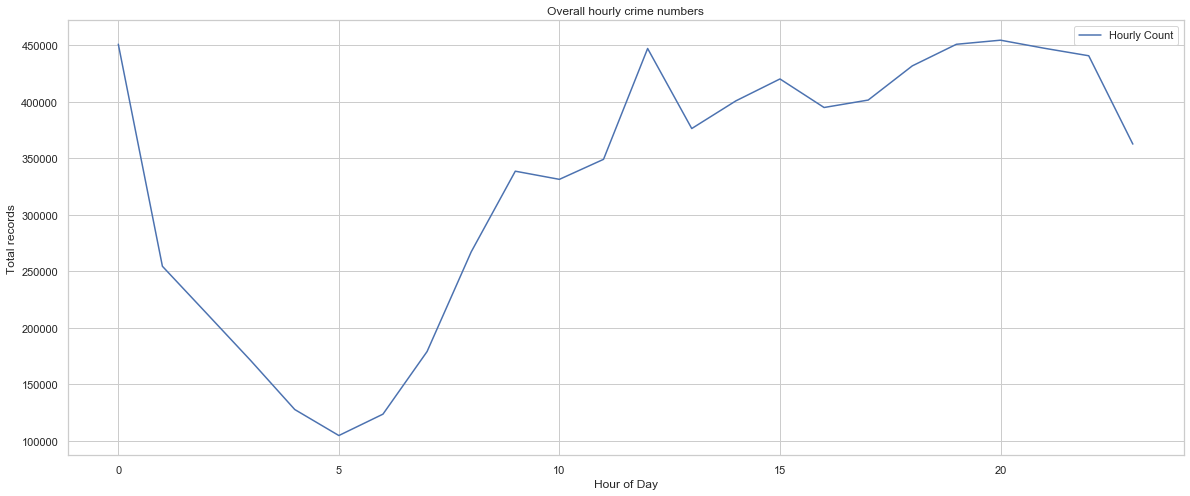

In [39]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

### Types of locations with crime entries

In [40]:
# Number of types of location recorded in the dataset
df.select('location_description').distinct().count()

173

What are the top 10 places where crime occurred?

In [47]:
location_hour = df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(10)

+--------------------+-------+
|location_description|  count|
+--------------------+-------+
|              STREET|2101843|
|           RESIDENCE|1341750|
|            SIDEWALK| 815595|
|           APARTMENT| 812512|
|               OTHER| 294286|
|PARKING LOT/GARAG...| 225454|
|               ALLEY| 180155|
|SCHOOL, PUBLIC, B...| 173750|
|    RESIDENCE-GARAGE| 158550|
|RESIDENCE PORCH/H...| 138492|
+--------------------+-------+
only showing top 10 rows



Can we see how the top crime locations are affected over the day?

In [48]:
#Being on the street and at home
street_home_hour = location_hour.where((location_hour['location_description'] == 'STREET') | (location_hour['location_description'] == 'RESIDENCE'))

AttributeError: 'NoneType' object has no attribute 'where'

In [ ]:
#a data frame with location descriptions and counts of recorded crimes, and hours...
street_home_hour_pddf = pd.DataFrame(street_home_hour.rdd.map(lambda row: row.asDict()).collect())
street_home_hour_pddf = street_home_hour_pddf.sort_values(by='hour')

In [ ]:
figure, axes = plt.subplots()
axes.plot(street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'RESIDENCE']['hour'], 
          street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'RESIDENCE']['count'],
         label='Crimes at home')

axes.plot(street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'STREET']['hour'], 
          street_home_hour_pddf[street_home_hour_pddf['location_description'] == 'STREET']['count'],
         label='Crimes on the street')

axes.legend()
ax.grid(b=True, which='both', axis='y')


#### This may be just me, but it seems that crimes at home increase when crimes on the street decrease. Could it be that it's the same kind of people that are in charge of both home and streets?

### Domestic crimes:

In [ ]:
domestic_hour = pd.DataFrame(df_hour.groupBy(['domestic', 'hour']).count().orderBy('hour').rdd.map(lambda row: row.asDict()).collect())

In [ ]:
dom = domestic_hour[domestic_hour['domestic'] == 'True']['count']
non_dom = domestic_hour[domestic_hour['domestic'] == 'False']['count']

either_dom = domestic_hour.groupby(by=['hour']).sum()['count']

dom_keys = domestic_hour[domestic_hour['domestic'] == 'False']['hour']

#### How do domestic crimes compare the other crimes?

In [ ]:
figure, axes = plt.subplots()

axes.plot(dom_keys, either_dom, label='Total hourly count')
axes.plot(dom_keys, dom, label='Domestic crime count')
axes.plot(dom_keys, non_dom, label='Non-Domestic hourly count')

axes.legend()
axes.grid(which='b', b=True)

### A closer look at crime date and time

The information given here indicates when the crime is perpetrated. The date/time field may be able to draw a meaningful trend that can be used to predict crime. However, I believe that this leads much more to external factors, such as policy changes, law inforcement-related factors, and so on.

It's much more likely that time-related features that are more closely relatable to crime occurence be better predictors than the date and time. I mean, knowing the month of the year, the day of the week, and the hour of the day that the crime occurred can enable better chances of predicting accurately than simply knowing "when" AD crimes occurred.

Adding predictors (so far fields) that read time information:

 * hour of day (already added the 'hour' field)
 * day of week
 * month of year
 * day in a range. Instead of using the entire date-time, we'll use a "day sequence" that is counted from 2001-01-01.

In [49]:
df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [50]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|01/01/2004 12:01:00 AM|2004-01-01|0   |5       |2004|1         |1        |1095       |
|03/01/2003 12:00:00 AM|2003-01-01|0   |7       |2003|3         |1        |789        |
|06/20/2004 11:00:00 AM|2004-01-01|11  |1       |2004|6         |20       |1266       |
|12/30/2004 08:00:00 PM|2004-01-01|20  |5       |2004|12        |30       |1459       |
|05/01/2003 01:00:00 AM|2003-01-01|1   |5       |2003|5         |1        |850        |
|08/01/2004 12:01:00 AM|2004-01-01|0   |1       |2004|8         |1        |1308       |
|01/01/2001 11:00:00 AM|2001-01-01|11  |2       |2001|1         |1        |0          |
|03/15/2003 12:00:00 AM|2003-01-01|0   |7       |2003|3         |15       |803        |
|09/16/2004 10:00:00 AM|2004-01-

## Day of week crime levels

It seems intriguing that the're little variance... But bad people are bad all week, aren't they...

In [51]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

In [52]:
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

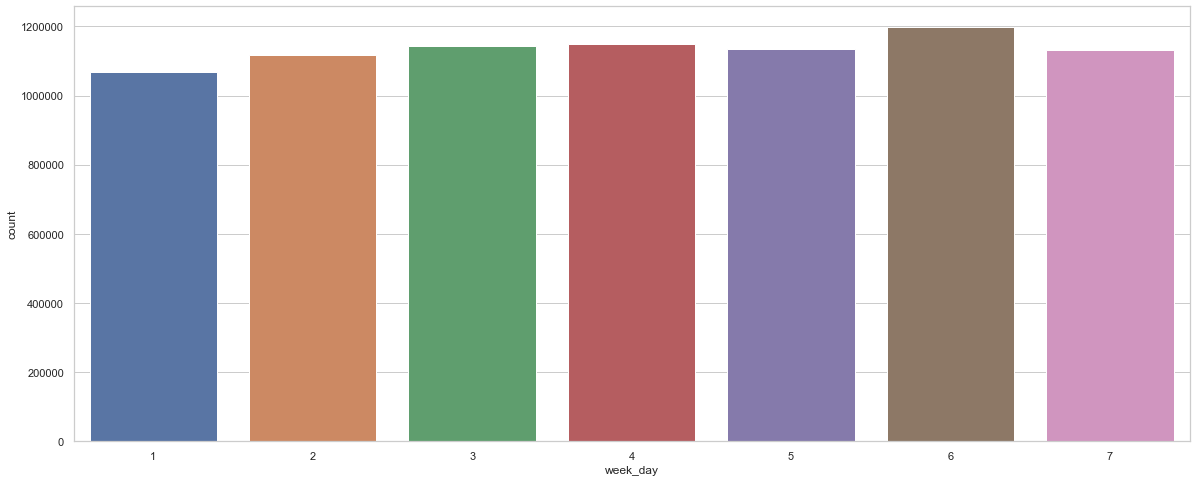

In [53]:
sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')

## Month of year

It seems that May-August are the busiest months for criminals... What could be the reason?

In [54]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

In [55]:
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

In [57]:
year_month_crime_counts_pddf

,year_month,count
0,1,660357
1,2,564178
2,3,639692
3,4,649755
4,5,730039
5,6,711768
6,7,730949
7,8,724522
8,9,679295
9,10,687450


What happens in MAY through AUGUST?

 * Salary increase season?
 * Weather?

I think these don't form the Christmas season in Chicago...

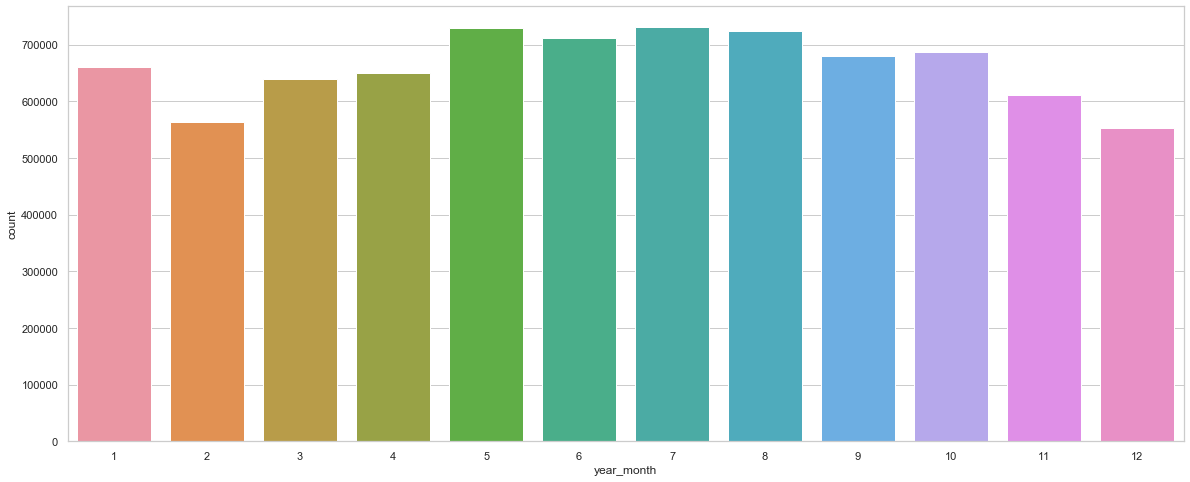

In [58]:
sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')

## Day of month

In [59]:
month_day_crime_counts = df_dates.groupBy('month_day').count()

In [60]:
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

#### Top 10 worst days of the month

In [61]:
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

,month_day,count
0,1,309994
14,15,271113
19,20,264762
9,10,263976
13,14,263507
11,12,263193
16,17,261727
8,9,261387
15,16,261078
7,8,260775


In [62]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

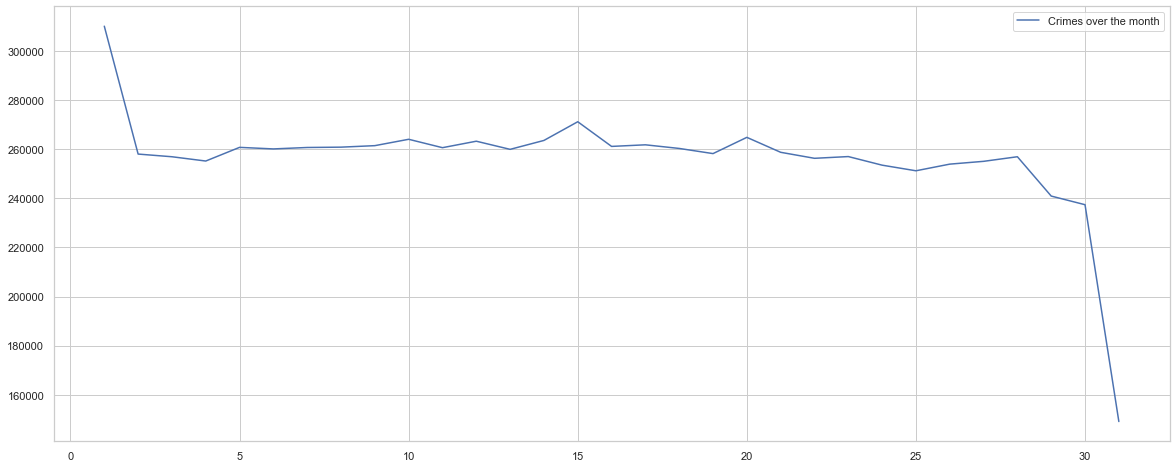

In [63]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

### Community areas?

Chicago has 77 community areas. How do they appear next to one another in a count plot?

In [64]:
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()

What are the to 10 areas with recorded crime?

In [65]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)

+--------------+------+
|community_area| count|
+--------------+------+
|          25.0|467137|
|          43.0|237381|
|           8.0|235562|
|          23.0|229024|
|          67.0|216991|
|          24.0|213915|
|          71.0|207183|
|          28.0|206017|
|          29.0|202887|
|          68.0|197659|
+--------------+------+
only showing top 10 rows



In [66]:
## Is it possible to see how the top crime types occur in the top crime-affected areas?
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [67]:
top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [68]:
top_crime_types_lst

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'OTHER OFFENSE',
 'ASSAULT',
 'BURGLARY',
 'MOTOR VEHICLE THEFT',
 'ROBBERY',
 'DECEPTIVE PRACTICE']

In [69]:
top_busy_areas_lst

['25.0', '43.0', '8.0', '23.0', '67.0', '24.0', '71.0', '28.0', '29.0', '68.0']

Find crimes of the top 10 types, that were perpetrated in the 10 10 busiest cities...

In [70]:
q1 = "instr('" + ' '.join(top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(top_crime_types_lst) + "', primary_type) > 0"
print(q1)

instr('25.0 43.0 8.0 23.0 67.0 24.0 71.0 28.0 29.0 68.0', community_area) > 0


In [71]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)

In [72]:
df_dates_tops.count()

2608136

In [73]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [74]:
tops_of_tops.show(20)

+------------+--------------+-----+
|primary_type|community_area|count|
+------------+--------------+-----+
|     ASSAULT|          25.0|27112|
|     ASSAULT|          43.0|16358|
|     ASSAULT|          67.0|15576|
|     ASSAULT|          68.0|15064|
|     ASSAULT|          71.0|14342|
|     ASSAULT|          23.0|14081|
|     ASSAULT|          29.0|12605|
|     ASSAULT|          28.0|11096|
|     ASSAULT|          24.0|10119|
|     ASSAULT|           8.0| 8385|
|     ASSAULT|           1.0| 6459|
|     ASSAULT|           3.0| 6335|
|     ASSAULT|           7.0| 2871|
|     ASSAULT|           4.0| 2427|
|     ASSAULT|           5.0| 1726|
|     ASSAULT|           9.0|  362|
|     BATTERY|          25.0|91430|
|     BATTERY|          43.0|51026|
|     BATTERY|          67.0|50855|
|     BATTERY|          68.0|49025|
+------------+--------------+-----+
only showing top 20 rows



#### Community area names

Let's link names of these community areas. These float numbers are having a hard time making any sense...

Sourced from Chicago Tribune at http://www.chicagotribune.com/chi-community-areas-htmlstory.html


In [75]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [76]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [77]:
code_pairs[:5]

[[1.0, 'Rogers Park'],
 [40.0, 'Washington Park'],
 [2.0, 'West Ridge'],
 [41.0, 'Hyde Park'],
 [3.0, 'Uptown']]

#### A view of crime count per community area

In [78]:
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())

In [79]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [80]:
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))

In [81]:
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

,community_area,count,community_area_name
22,0.0,114,unknown_0.0
24,9.0,6983,Edison Park
11,47.0,10957,Burnside
25,12.0,12969,Forest Glen
53,55.0,15554,Hegewisch


**What is happening in Austin?**

plt.rcParams["figure.figsize"] = [32, 32]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
area_chart = sns.barplot(x='count', y='community_area_name', data=community_area_counts)
area_chart.set(ylabel="Community Area Name", xlabel="Overall Crimes Record Count")

** *Join these community areas on the main data frame* **

In [82]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])

In [83]:
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')

In [84]:
named_tops_of_tops.show(10)

+--------------+---------------+-------------------+-----+
|community_area|      area_name|       primary_type|count|
+--------------+---------------+-------------------+-----+
|           8.0|Near North Side|            ASSAULT| 8385|
|           8.0|Near North Side|            BATTERY|31008|
|           8.0|Near North Side|           BURGLARY| 5635|
|           8.0|Near North Side|    CRIMINAL DAMAGE|15840|
|           8.0|Near North Side| DECEPTIVE PRACTICE|20796|
|           8.0|Near North Side|MOTOR VEHICLE THEFT| 4961|
|           8.0|Near North Side|          NARCOTICS|12647|
|           8.0|Near North Side|      OTHER OFFENSE| 8621|
|           8.0|Near North Side|            ROBBERY| 5763|
|           8.0|Near North Side|              THEFT|96280|
+--------------+---------------+-------------------+-----+
only showing top 10 rows



In [85]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )

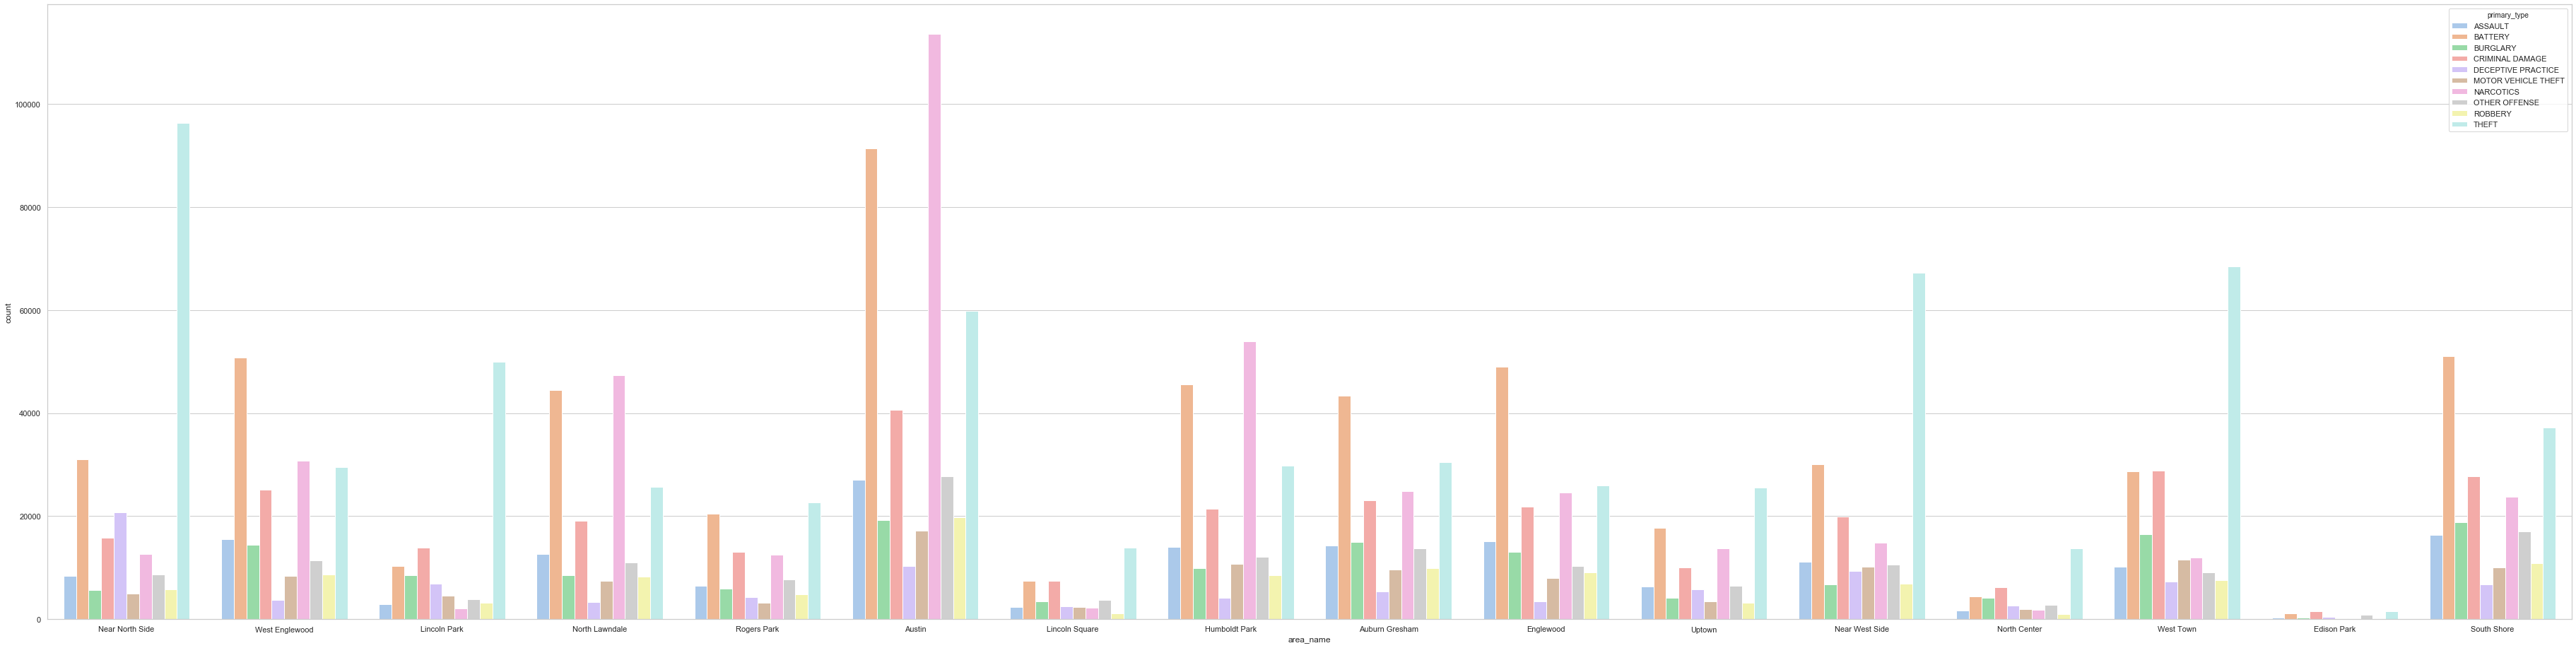

In [86]:
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')

---


# Can we try to predict the primary type of crime?

Now on to another objective of this exercise. We're going to try to predict what kind of crime is going to occur given the selected features.

Speaking about features, here's the list of predictors that I chose to go for:

### Excluded variables:

 * 'id' - Random information that isn't a predictor of crime type
 * 'case_number' - Random information that isn't a predictor of crime type
 * 'date' - Removed because it's been re-featurized in other features generated above
 * 'block' - Excluded as this may simply mean noise
 * 'iucr' - Excluded as correlated with crime type. No point.
 * 'x_coordinate' - Not included
 * 'y_coordinate' - Not included
 * 'year' - Not included (already otherwise featurized)
 * 'updated_on' - not included
 * 'latitude' - not included
 * 'longitude' - not included
 * 'location' - not included
 * 'date_time' - Taken into account in other time-related features
 * 'description' - Excluded. I want to see this as associated with the response (primary type)


### Selected predictors:

 * 'location_description'
 * 'arrest'
 * 'domestic'
 * 'beat'
 * 'district'
 * 'ward'
 * 'community_area'
 * 'fbi_code'
 * 'hour'
 * 'week_day'
 * 'year_month'
 * 'month_day'
 * 'date_number'

In [87]:
selected_features = [
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number']

In [88]:
#Let's see the schema of these selected features:
features_df = df_dates.select(selected_features)
features_df.printSchema()

root
 |-- location_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- week_day: integer (nullable = true)
 |-- year_month: integer (nullable = true)
 |-- month_day: integer (nullable = true)
 |-- date_number: integer (nullable = true)



Let's try to see all level counts in all the selected features...

In [89]:
feature_level_count_dic = []

for feature in selected_features:
    print('Analysing %s' % feature)
    levels_list_df = features_df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})


Analysing location_description
Analysing arrest
Analysing domestic
Analysing beat
Analysing district
Analysing ward
Analysing community_area
Analysing fbi_code
Analysing hour
Analysing week_day
Analysing year_month
Analysing month_day
Analysing date_number


In [90]:
pd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)

,feature,level_count
12,date_number,5862
3,beat,304
0,location_description,173
6,community_area,79
5,ward,51
11,month_day,31
4,district,27
7,fbi_code,26
8,hour,24
10,year_month,12


### Preparing model

In [91]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
df_dates_features = df_dates.na.drop(subset=selected_features)

Let us use Spark's string indexer to index selected features

In [ ]:
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming "%s"' % feature['feature'])
    df_dates_features = model.transform(df_dates_features)

Now let's do the same with the label

In [ ]:
## String-index the response variable:
response_indexer = StringIndexer(inputCol='primary_type', outputCol='primary_type_indexed')
response_model = response_indexer.fit(df_dates_features)
df_dates_features = response_model.transform(df_dates_features)

In [ ]:
#What does it look like now...
df_dates_features.show(1)

Let's vectorize the features

We use a vector assembler to vectorize all predictors into a `features` column

In [ ]:
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

In [ ]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_dates_features)

In [ ]:
vectorized_df_dates.select('features').take(1)

### Now let's train the model.

We're using **60%** to **40%** split between the train and the test datasets

Let's try to train a logistic regression.

In [ ]:
train, test = vectorized_df_dates.randomSplit([0.6, 0.4])

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
logisticRegression = LogisticRegression(labelCol='primary_type_indexed', featuresCol='features', maxIter=10, family='multinomial')

In [ ]:
fittedModel = logisticRegression.fit(train)

## Model performance?

In [ ]:
fittedModel.summary.accuracy

In [ ]:
model_summary = fittedModel.summary

In [ ]:
fittedModel.coefficientMatrix

#### Why the 34X13 shape?

That's because the multinomial logistic regression is fitted on **each class** of the label. It computes the probability of each class and then predicts based on these probabilities.

In [ ]:
print(fittedModel.coefficientMatrix)

In [ ]:
print('Coefficient matrix:\nRow count = %s\nCol count = %s' % (fittedModel.coefficientMatrix.numRows, fittedModel.coefficientMatrix.numCols))

In [ ]:
print('Model:\nNum Classes = %s\nNum Features = %s' % (fittedModel.numClasses, fittedModel.numFeatures))

In [ ]:
print('Training "primary_type" factor level count = %s' % train.select('primary_type_indexed').distinct().count())

So our `randomSplit` call to split train/test data sets took some primary types to only either of the two parts

In [ ]:
vectorized_df_dates.select('features').show(2, truncate=False)

In [ ]:
fittedModel.numClasses

In [ ]:
fittedModel.numFeatures

In [ ]:
train.select('primary_type_indexed').distinct().count()

In [ ]:
df_dates.select('primary_type').distinct().count()

In [ ]:
fittedModel.interceptVector.values.size

In [ ]:
print(model_summary.objectiveHistory)
print()
print('Objective history size ', len(model_summary.objectiveHistory))

In [ ]:
sns.barplot(y=model_summary.objectiveHistory, x=list(range(len(model_summary.objectiveHistory))))

In [ ]:
label_stats = {float(i):{'index': float(i)} for i in range(34)}
print(label_stats)

In [ ]:
print("False positive rate by label:")
for i, rate in enumerate(model_summary.falsePositiveRateByLabel):
    label_stats[i]['false_positive_rate'] = rate
    
for i, rate in enumerate(model_summary.truePositiveRateByLabel):
    label_stats[i]['true_positive_rate'] = rate
    
for i, rate in enumerate(model_summary.precisionByLabel):
    label_stats[i]['precision_rate'] = rate
    
for i, rate in enumerate(model_summary.recallByLabel):
    label_stats[i]['recall_rate'] = rate
    
for i, rate in enumerate(model_summary.fMeasureByLabel()):
    label_stats[i]['f_measure'] = rate

In [ ]:
train_rdd = train.select(['primary_type', 'primary_type_indexed']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()


In [ ]:
for l in train_rdd:
    print(l)
    label_stats[l['primary_type_indexed']]['primary_type'] = l['primary_type']

In [ ]:
rates_pddf = pd.DataFrame(list(label_stats.values()))

In [ ]:
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)

#### Why does this model seem to be so good at predicting theft? (TODO)

In [ ]:
rates_pddf

## TODO:

 * Run the model on the test dataset